In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv, matplotlib.pyplot as plt, pandas as pd
import torch.nn as nn, timeit, torch, pystan as ps, scipy, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="/home/postdoc/dsen/Desktop/codes/BNN_dimension_reduction/stan_files/nn_refpoints_constrainedtheta.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf61588642e0539b092dedc55e934141 NOW.


In [3]:
inp_data = (pd.read_csv("ecoli.data", header=0).values)[:,0]

X = np.zeros((7,len(inp_data)))
for i in range(len(inp_data)) :
    X[0,i] = float(inp_data[i][12:16])
    X[1,i] = float(inp_data[i][18:22])
    X[2,i] = float(inp_data[i][24:28])
    X[3,i] = float(inp_data[i][30:34])
    X[4,i] = float(inp_data[i][36:40])
    X[5,i] = float(inp_data[i][42:46])
    X[6,i] = float(inp_data[i][48:52])
Nobs = np.shape(X)[1]

In [4]:
print("Nobs =", Nobs)

Nobs = 335


### Local linear embedding for reference points:

In [5]:
n_ref = 20
lat_dim = 1
obs_dim = np.shape(X)[0] 
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=lat_dim, n_neighbors=10)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [6]:
ref_points

array([ 89, 228, 272, 209, 282,  54,  47, 306, 246,  51, 317, 254, 289,
        81, 316,  35, 101, 312, 221, 174])

In [7]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [8]:
n_in = np.shape(X_embedded)[0]
n_h = 5
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h), nn.Tanh(), nn.Linear(n_h, n_out))

In [9]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [10]:
n_iter = 100_000
Lss = np.zeros(n_iter)
start = time()
for epoch in range(n_iter):
    X_pred = model(torch.from_numpy(Z_ref.transpose().astype(np.float32)))
    loss = criterion(X_pred, torch.from_numpy(X_ref.transpose().astype(np.float32)))
    Lss[epoch] = loss.data
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 10000; loss: 0.024; time: 0.0 mins
Epoch: 20000; loss: 0.023; time: 0.1 mins
Epoch: 30000; loss: 0.023; time: 0.1 mins
Epoch: 40000; loss: 0.023; time: 0.1 mins
Epoch: 50000; loss: 0.023; time: 0.2 mins
Epoch: 60000; loss: 0.023; time: 0.2 mins
Epoch: 70000; loss: 0.023; time: 0.2 mins
Epoch: 80000; loss: 0.023; time: 0.3 mins
Epoch: 90000; loss: 0.023; time: 0.3 mins
Epoch: 100000; loss: 0.023; time: 0.3 mins


In [11]:
for (i,p) in enumerate(model.parameters()):
    if i == 0 : W_1_optim = p.data
        
c = [np.linalg.norm(W_1_optim[i,:]) for i in range(n_in)]
for i in range(n_ref) : Z_ref[:,i] *= c

### Run Stan:

In [12]:
data = dict(Nobs=Nobs, in_dim=n_in, out_dim=n_out, hidden_dim=n_h, n_ref=n_ref, X=X_train, X_ref=X_ref, Z_ref=Z_ref)

In [13]:
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=12, chains=12, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

18.01 minutes to run
Inference for Stan model: anon_model_cf61588642e0539b092dedc55e934141.
12 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=6000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]              0.38    0.58   1.44  -1.81  -1.16   1.09   1.63   2.23      6   5.15
Z[2,1]           -3.6e-3    0.18   0.56  -1.09   -0.4  -0.01    0.4   1.07     10   1.64
Z[3,1]              0.02    0.07   0.32  -0.59  -0.18   0.01   0.22   0.67     20   1.21
Z[4,1]              0.26    0.55   1.38  -1.96  -1.14   0.88   1.38   2.28      6   4.53
Z[5,1]              0.21    0.24   0.65  -0.66  -0.18   0.09   0.37   2.08      7   2.32
Z[6,1]             -0.05    0.51   1.29   -2.0  -1.25   0.03   1.17   1.75      6   4.18
Z[7,1]             -0.01    0.52   1.32  -1.93  -1.28   0.03   1.26   1.82      6   4.38
Z[8,1]             -0.11    0.63   1.57   -2.3  -1.49  -0.79   1.54   2.38     

In [31]:
trace = fit.extract()
np.save('/xtmp/BNN_dim_red_data/stan_fit_ecoli.npy', trace) 
# trace = np.load('stan_fit_ecoli.npy',allow_pickle='TRUE').item()
n_samples, n_latent = np.shape(trace['Z'])[0], np.shape(trace['Z'])[1]

#### Traceplots of latent variables:

Text(0.5, 0.95, 'Traceplots of some latent variables')

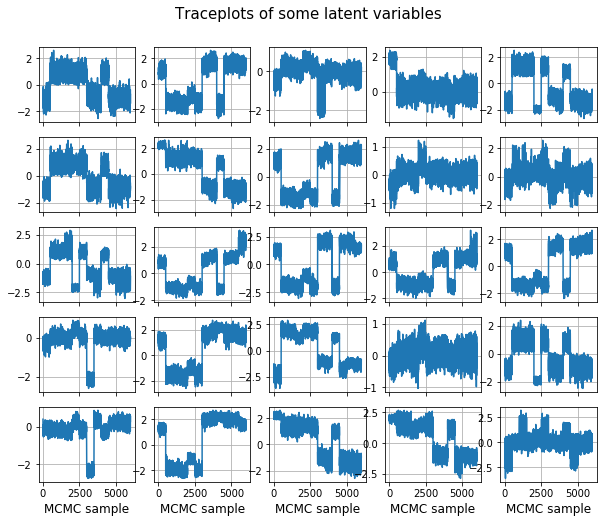

In [15]:
plt.figure(figsize=(10,8))
idx = npr.choice(n_latent,25).reshape(5,5)

for i in range(5):
    for j in range(5):
        k = 5*i+j
        plt.subplot(5,5,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 4 : plt.xticks(alpha=0)
        if i == 4 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=15, x=0.5,y=0.95)
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_traceplot_constrainedW1_refpoints.pdf', 
#                 dpi=2000, bbox_inches='tight');

### Loss:

In [16]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

100%|██████████| 6000/6000 [00:00<00:00, 15851.38it/s]


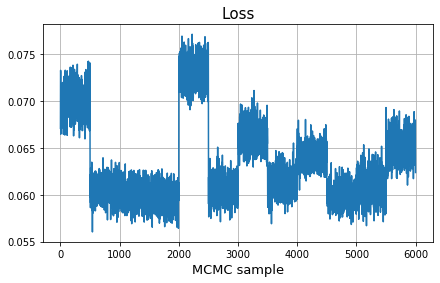

In [17]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), trace['Z'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_loss.pdf', dpi=2000, bbox_inches='tight');

### Pairwise distances:

In [18]:
n_samples, n_latent = np.shape(trace['Z'])[0], np.shape(trace['Z'])[1]
k_max = 50
pw_dist_matrix = np.zeros((k_max,k_max,n_samples))
for k in trange(n_samples) :
    for i in range(k_max) :
        for j in range(k_max) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

100%|██████████| 6000/6000 [01:17<00:00, 77.73it/s]


Text(0.31, 0.83, 'Traceplots of some pairwise distances of latent variables for E. coli data')

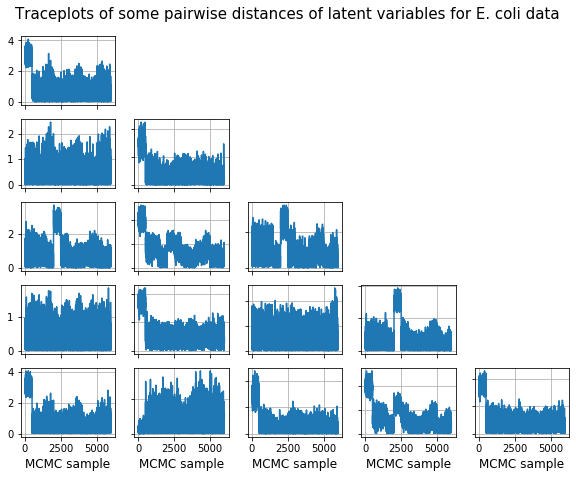

In [19]:
k_max = 50
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 5 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
plt.suptitle("Traceplots of some pairwise distances of latent variables for E. coli data", fontsize=15, x=0.31,y=0.83)
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_pwdist_constrainedW1_refpoints.pdf', 
#                 dpi=2000, bbox_inches='tight');

### Summaries of pairwise distances:

In [20]:
latent_samples = np.zeros((Nobs,n_samples,lat_dim))
k = 0
ref_points_sorted = np.sort(ref_points)
Z_ref_sorted = Z_ref[:,np.argsort(ref_points)]
for i in range(Nobs) :
    if k < len(ref_points_sorted) :
        if i == ref_points_sorted[k] :
            latent_samples[i] = Z_ref[:,k]
            k += 1 
        else :
            latent_samples[i] = trace['Z'][:,i-k]
np.save('/xtmp/BNN_dim_red_data/ecoli_latent_samples.npy', latent_samples)

In [21]:
pw_dist_summary = np.zeros((4,Nobs,Nobs))
for i in trange(Nobs) :
    for j in range(Nobs) :
        pwdist = scipy.linalg.norm(latent_samples[i]-latent_samples[j], axis=1)
        pw_dist_summary[0,i,j] = np.mean(pwdist)
        pw_dist_summary[1,i,j] = np.median(pwdist)
        pw_dist_summary[2,i,j] = np.percentile(pwdist,q=2.5)
        pw_dist_summary[3,i,j] = np.percentile(pwdist,q=97.5)
np.save('/xtmp/BNN_dim_red_data/ecoli_pw_dist_summary.npy', pw_dist_summary)

100%|██████████| 335/335 [00:36<00:00,  9.64it/s]


In [23]:
class_lab = np.zeros(Nobs).astype(int)
class_names = ['imS', 'imL', 'omL', ' cp', ' im', 'imU', ' om', ' pp']
for i in range(Nobs) :
    for j in range(len(class_names)) :
        if inp_data[i][54:57] == class_names[j] :
            class_lab[i] = j

In [24]:
latent_samples_sorted = latent_samples[np.argsort(class_lab)]
pw_dist_summary_sorted = np.zeros((4,Nobs,Nobs))
for i in trange(Nobs) :
    for j in range(Nobs) :
        pwdist = scipy.linalg.norm(latent_samples_sorted[i]-latent_samples_sorted[j], axis=1)
        pw_dist_summary_sorted[0,i,j] = np.mean(pwdist)
        pw_dist_summary_sorted[1,i,j] = np.median(pwdist)
        pw_dist_summary_sorted[2,i,j] = np.percentile(pwdist,q=2.5)
        pw_dist_summary_sorted[3,i,j] = np.percentile(pwdist,q=97.5)
np.save('/xtmp/BNN_dim_red_data/ecoli_latent_samples_sorted.npy', latent_samples_sorted)
np.save('/xtmp/BNN_dim_red_data/ecoli_pw_dist_summary_sorted.npy', pw_dist_summary_sorted)

100%|██████████| 335/335 [00:36<00:00,  9.22it/s]


In [25]:
class_lab_sorted = np.sort(class_lab)
for i in range(len(np.unique(class_lab))) :
    print(np.sum(class_lab_sorted == i))

2
2
5
142
77
35
20
52


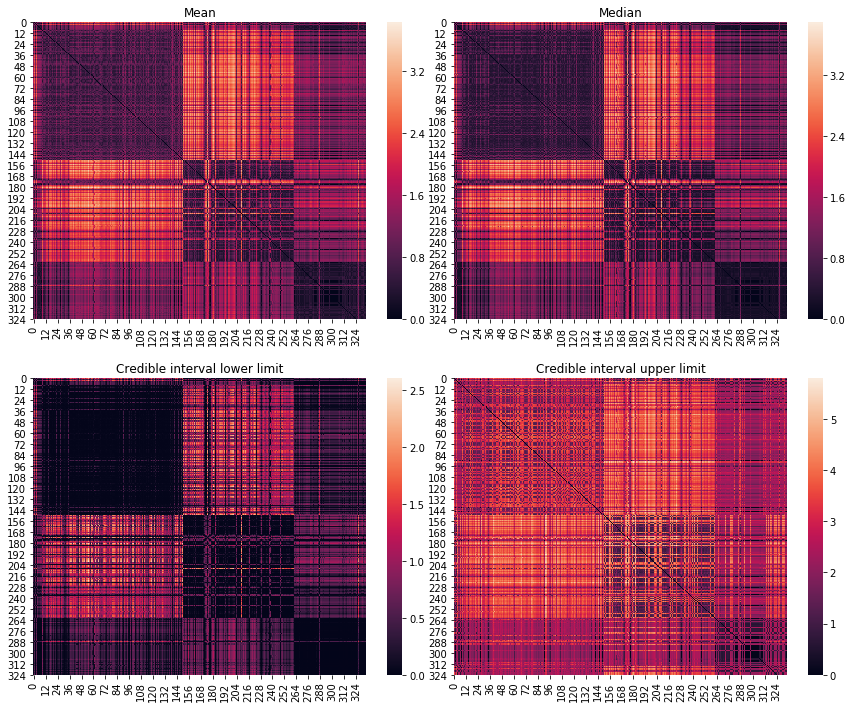

In [26]:
titles = ["Mean", "Median", "Credible interval lower limit", "Credible interval upper limit"]
fig = plt.figure(figsize=(15,12))
for i in range(4) :
    plt.subplot(2,2,i+1)
    ax = sns.heatmap(pw_dist_summary_sorted[i])
    plt.title(titles[i])
# plt.show()
plt.subplots_adjust(wspace=1e-2)
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_pwdist_heatmap.pdf', dpi=1000, box_inches='tight')
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_pwdist_heatmap.jpeg', dpi=1000, box_inches='tight')

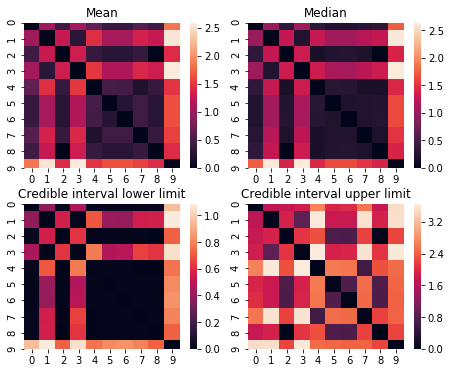

In [27]:
titles = ["Mean", "Median", "Credible interval lower limit", "Credible interval upper limit"]
fig = plt.figure(figsize=(7.5,6))
for i in range(4) :
    plt.subplot(2,2,i+1)
    ax = sns.heatmap(pw_dist_summary_sorted[i][:10,:10])
    plt.title(titles[i])
# plt.show()
plt.subplots_adjust(wspace=1.5e-1,hspace=2.5e-1)
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_pwdist_heatmap.pdf', dpi=1000, box_inches='tight')
# plt.savefig('/xtmp/BNN_dim_red_data/ecoli_pwdist_heatmap_small.jpeg', dpi=1000, box_inches='tight')

In [30]:
np.shape(latent_samples_sorted)

(335, 6000, 1)